## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [14]:
from IPython.display import clear_output
from random import sample
import string
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

In [16]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [17]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text =  ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [18]:
# text = text.replace('\r\n', ' ')
# text = text.replace('\n', ' ')
# text = text.replace('-', ' ')

In [19]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [20]:
# dict <index>:<char>
# Your great code here
token_to_id = {
    token: idx for idx, token in enumerate(tokens)
}
# dict <char>:<index>
# Your great code here
idx_to_token = {idx: word for word, idx in token_to_id.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [21]:
num_tokens = len(tokens)
num_tokens

38

In [22]:
encoded = np.array([token_to_id[ch] for ch in text])

In [23]:
int(len(encoded) / (100 * 32))

31

In [24]:
seq_size = 32
batch_size = 32
lstm_size=38
embedding_size=38

In [25]:
num_batches = int(len(encoded) / (seq_size * batch_size))
in_text = encoded[:num_batches * batch_size * seq_size]
out_text = np.zeros_like(in_text)
out_text[:-1] = in_text[1:]
out_text[-1] = in_text[0]
in_text = np.reshape(in_text, (batch_size, -1))
out_text = np.reshape(out_text, (batch_size, -1))

In [26]:
encoded.shape, num_batches * batch_size * seq_size

((100225,), 99328)

In [27]:
in_text.shape, out_text.shape, np.prod(in_text.shape) // (seq_size * batch_size)

((32, 3104), (32, 3104), 97)

In [28]:
out_text[0:0+seq_size]

array([[ 1, 17, 29, ..., 26, 29,  1],
       [25, 26,  1, ..., 14, 19,  1],
       [31, 26,  1, ..., 31, 16, 31],
       ...,
       [ 1, 16, 36, ..., 20, 25, 15],
       [10,  0,  1, ..., 16, 12, 33],
       [16, 25,  1, ..., 36, 16,  1]])

In [29]:
def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

In [30]:
class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(n_vocab,
                            lstm_size,
                            batch_first=True)
        self.dense = nn.Linear(lstm_size, num_tokens)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state        
        
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))

In [31]:
net = RNNModule(num_tokens, seq_size, embedding_size, lstm_size)
iteration = 0

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [33]:
initial_words=['I', 'am'],
def predict(net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
    net.eval()
    state_h, state_c = net.zero_state(1)
    for w in words:
        ix = torch.tensor([[token_to_id[w]]])
        output, (state_h, state_c) = net(ix, (state_h, state_c))
    
    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])
    for _ in range(100):
        ix = torch.tensor([[choice]])
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words))

In [34]:
epoch_loss = []
best_loss = np.inf
for e in range(200):
    batches = get_batches(in_text, out_text, batch_size, seq_size)
    state_h, state_c = net.zero_state(batch_size)

    for x, y in batches:
        iteration += 1

        # Tell it we are in training mode
        net.train()

        # Reset all gradients
        optimizer.zero_grad()

        # Transfer data to GPU
        x = torch.tensor(x).to(torch.int64)
        y = torch.tensor(y).to(torch.int64)

        logits, (state_h, state_c) = net(x, (state_h, state_c))
        loss = criterion(logits.transpose(1, 2), y)

        state_h = state_h.detach()
        state_c = state_c.detach()

        loss_value = loss.item()

        # Perform back-propagation
        loss.backward()

        _ = torch.nn.utils.clip_grad_norm_(
            net.parameters(), 5)

        optimizer.step()
        if iteration % 100 == 0:
            print('Epoch: {}/{}'.format(e, 200),
                      'Iteration: {}'.format(iteration),
                      'Loss: {}'.format(loss_value))

#             if iteration % 1000 == 0:
    if loss_value < best_loss:
#         predict(net, initial_words, num_tokens,
#                 token_to_id, idx_to_token, top_k=5)
        torch.save(net.state_dict(),
                   'checkpoint_pt/model-{}.pth'.format(iteration))
            
    epoch_loss.append(loss_value)

Epoch: 1/200 Iteration: 100 Loss: 1.9121330976486206
Epoch: 2/200 Iteration: 200 Loss: 1.878706693649292
Epoch: 3/200 Iteration: 300 Loss: 1.8017863035202026


KeyboardInterrupt: 

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [60]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [61]:
words = text.split()

In [62]:
print('\n'.join(words[::2000]))
print(to_matrix(words[::2000]))

from
fair
and
by
being
sleep
beloved
retention
foes,
[[15 27 24 22  0  0  0  0  0]
 [15 10 18 27  0  0  0  0  0]
 [10 23 13  0  0  0  0  0  0]
 [11 34  0  0  0  0  0  0  0]
 [11 14 18 23 16  0  0  0  0]
 [28 21 14 14 25  0  0  0  0]
 [11 14 21 24 31 14 13  0  0]
 [27 14 29 14 23 29 18 24 23]
 [15 24 14 28  5  0  0  0  0]]


In [63]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE    
        h_next = torch.tanh(h_next) # YOUR CODE HERE
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)# YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [64]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

In [65]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [66]:
batch_ix = to_matrix(words[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [67]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                  actual_next_tokens.contiguous().view(-1))

In [68]:
predictions_logp.shape

torch.Size([5, 8, 36])

In [69]:
actual_next_tokens.shape

torch.Size([5, 8])

In [70]:
loss.backward()

In [71]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

In [72]:
loss

tensor(3.5736, grad_fn=<NllLossBackward>)

In [73]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

max length = 14


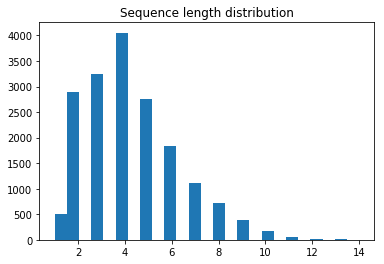

In [74]:
MAX_LENGTH = max(map(len, words))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, words)),bins=25);

In [160]:
len(words) / 32

555.4375

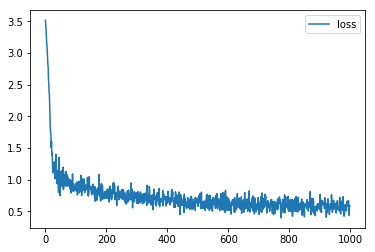

In [76]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(words, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    ) # YOUR CODE HERE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    # YOUR CODE HERE
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [77]:
# Your plot here

In [103]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [106]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [158]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))
print(generate_sample(char_rnn, seed_phrase = 'wi', max_length=20, temperature=0.001))

with                


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)